###**Import Necessary Libraries**

In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.optimizers import SGD
from keras import backend as K
from PIL import Image

import tensorflow as tf
%tensorflow_version 1.x
import numpy as np, os, sys, pickle, gzip, urllib.request, time
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


###**Google Drive Authentication**

In [2]:
path = '/content/drive/My Drive/Project2/'
from google.colab import drive
drive.mount('/content/drive')
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


###**Generate Input and Label Vectors**

In [0]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/setup_mnist.py

def get_labels(filename, image_count):
    with gzip.open(filename) as file:
        file.read(8)
        buf = file.read(1 * image_count)
        labels = np.frombuffer(buf, dtype = np.uint8)
        ret_labels = (np.arange(10) == labels[:, None]).astype(np.float32)
    return (ret_labels)
    
def get_data(filename, image_count):
    with gzip.open(filename) as file:
        file.read(16)
        buf = file.read(image_count * 28 * 28)
        data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        data /= 255
        data -= 0.5 
        data = data.reshape(image_count, 28, 28, 1)
        return (data)


###**Download MNIST Data**

In [4]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/setup_mnist.py

if not os.path.exists("data"):
  os.mkdir("data")
  source_files = ["train-images-idx3-ubyte.gz", "t10k-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-labels-idx1-ubyte.gz"] #Source Files
  for name in source_files:
    urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' + name, 'data/' +name) #Get MNIST Data

X_train = get_data('data/train-images-idx3-ubyte.gz', 60000)
Y_train = get_labels('data/train-labels-idx1-ubyte.gz', 60000)
X_test = get_data('data/t10k-images-idx3-ubyte.gz', 10000)
Y_test = get_labels('data/t10k-labels-idx1-ubyte.gz', 10000)

valiation_size = 5000 #Size of Valudation Set

X_valid = X_train[: valiation_size, :, :, :]
Y_valid = Y_train[: valiation_size]
X_train = X_train[valiation_size :, :, :, :]
Y_train = Y_train[valiation_size :]

print('Shapes of Datasets \n')
print('Shape of Training Data: {}'.format(X_train.shape))
print('Shape of Training Labels: {}'.format(Y_train.shape))
print('Shape of Validation Data: {}'.format(X_train.shape))
print('Shape of Validation Labels: {}'.format(Y_train.shape))
print('Shape of Test Data: {}'.format(X_test.shape))
print('Shape of Test Labels: {}'.format(Y_test.shape))

Shapes of Datasets 

Shape of Training Data: (55000, 28, 28, 1)
Shape of Training Labels: (55000, 10)
Shape of Validation Data: (55000, 28, 28, 1)
Shape of Validation Labels: (55000, 10)
Shape of Test Data: (10000, 28, 28, 1)
Shape of Test Labels: (10000, 10)


###**Define MNIST Model**

In [0]:
#Reference https://github.com/carlini/nn_robust_attacks/blob/master/setup_mnist.py

class MNISTModel(object):
    def __init__(self, restore, session = None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        
        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))
        model.load_weights(restore)

        self.model = model

    def predict(self, data):
        return self.model(data)

###**Create and train CNN Network**

In [0]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/train_models.py

def train(X_train, Y_train, X_valid, Y_valid, file_name, params, num_epochs = 50, batch_size = 128, train_temp = 1, init = None):
    
    model = Sequential()
    model.add(Conv2D(params[0], (3, 3), input_shape = X_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels = correct, logits = predicted/train_temp)

    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)#implementing Stochastic gradient descent 
    
    model.compile(loss = fn, optimizer=sgd, metrics=['accuracy'])
    
    model.fit(X_train, Y_train, batch_size = batch_size, validation_data = (X_valid, Y_valid), nb_epoch = num_epochs, shuffle = True)
  
    if file_name != None:
        model.save(file_name)

    return model

###**Create and train CNN Network using Defensive Distillation**

In [0]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/train_models.py

def train_distillation(X_train, Y_train, X_valid, Y_valid, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(X_train, Y_train, X_valid, Y_valid, file_name +"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(X_train, Y_train, X_valid, Y_valid, file_name +"_teacher", params, num_epochs, batch_size, train_temp, init = file_name +"_init")

    # get soft labels
    predicted = teacher.predict(X_train)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        Y_train = y

    # train the student model at temperature t
    student = train(X_train, Y_train, X_valid, Y_valid, file_name, params, num_epochs, batch_size, train_temp, init = file_name + "_init")

    # and finally we predict at temperature 1
    predicted = student.predict(X_train)

    print(predicted)

###**Train and Save Models**

In [0]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/train_models.py

if not os.path.isdir('models'):
    os.makedirs('models')

start_time = time.time()

train(X_train, Y_train, X_valid, Y_valid, "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs = 50)
train_distillation(X_train, Y_train, X_valid, Y_valid, "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200], num_epochs = 50, train_temp = 100)

print("--- Training Time: %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 131s 2ms/step - loss: 0.6577 - acc: 0.7744 - val_loss: 0.0987 - val_acc: 0.9702
Epoch 2/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.1241 - acc: 0.9621 - val_loss: 0.0628 - val_acc: 0.9814
Epoch 3/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0901 - acc: 0.9725 - val_loss: 0.0511 - val_acc: 0.9862
Epoch 4/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0713 - acc: 0.9789 - val_loss: 0.0439 - val_acc: 0.9882
Epoch 5/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0610 - acc: 0.9807 - val_loss: 0.0418 - val_acc: 0.9882
Epoch 6/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.0510 - acc: 0.9843 - val_loss: 0.0366 - val_acc: 0.9910
Epoch 7/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0447 - acc: 0.9860 - val_loss: 0.0376 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 130s 2ms/step - loss: 0.6631 - acc: 0.7799 - val_loss: 0.0901 - val_acc: 0.9724


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 131s 2ms/step - loss: 0.4468 - acc: 0.9259 - val_loss: 0.1007 - val_acc: 0.9690
Epoch 2/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.1376 - acc: 0.9577 - val_loss: 0.0788 - val_acc: 0.9768
Epoch 3/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.1123 - acc: 0.9661 - val_loss: 0.0691 - val_acc: 0.9800
Epoch 4/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0950 - acc: 0.9710 - val_loss: 0.0606 - val_acc: 0.9818
Epoch 5/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.0875 - acc: 0.9726 - val_loss: 0.0564 - val_acc: 0.9840
Epoch 6/50
55000/55000 [==============================] - 131s 2ms/step - loss: 0.0772 - acc: 0.9767 - val_loss: 0.0527 - val_acc: 0.9844
Epoch 7/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0715 - acc: 0.9781 - val_loss: 0.0509 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.4410 - acc: 0.9286 - val_loss: 0.1021 - val_acc: 0.9700
Epoch 2/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.1349 - acc: 0.9587 - val_loss: 0.0776 - val_acc: 0.9768
Epoch 3/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.1081 - acc: 0.9668 - val_loss: 0.0653 - val_acc: 0.9812
Epoch 4/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.0938 - acc: 0.9707 - val_loss: 0.0603 - val_acc: 0.9812
Epoch 5/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.0812 - acc: 0.9749 - val_loss: 0.0588 - val_acc: 0.9830
Epoch 6/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0742 - acc: 0.9768 - val_loss: 0.0521 - val_acc: 0.9836
Epoch 7/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0685 - acc: 0.9786 - val_loss: 0.0488 - v

###**Generate and store Targeted Adversarial Images using L2 Attack**

In [0]:
#This block of code has been solely referred from: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py.

BINARY_SEARCH_STEPS = 9  # numerical count to adjust binary search constant
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early i.e early stopping
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class l2_attack: #Euclidean Attack for generation of adversarial examples
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE, targeted = TARGETED, learning_rate = LEARNING_RATE, binary_search_steps = BINARY_SEARCH_STEPS, 
                 max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY, initial_const = INITIAL_CONST, boxmin = -0.5, boxmax = 0.5):

        image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10
        self.override_softmax_check = False

        shape = (batch_size,image_size, image_size, num_channels)
        
        # the variable we shall to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)						#create a graph element for holding images
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)    #create a graph element for holding labels
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)				
   
        self.assign_timg = tf.placeholder(tf.float32, shape)						    #placeholder for images
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))          #placeholder for labels
        self.assign_const = tf.placeholder(tf.float32, [batch_size])					#the constant "c"
        
        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
        
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus   #convert to tanh space and restrict the image to boxmin and boxmax.
                                                                                    #We convert into tanh space to solve the optimization problem		    
        self.output = model.predict(self.newimg)		#output of the model 
        
        # Calculate the l2 distance (eucledian distance) between the image being poissoned and the original image
        self.l2dist = tf.reduce_sum(tf.square(self.newimg - (tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])  
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1 - self.tlab) * self.output - (self.tlab * 10000), 1)

        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other - real + self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real - other + self.CONFIDENCE)
        
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1 + self.loss2						#objective function
        
        # add the optimizer to the graph. As mentioned in the paper we are using Adam's optimizer.  
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)  			 		  
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        #create a variable to store the progress during the execution of the graph 
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    def attack_batch(self, imgs, labs): #Executing Attack
    	# reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y
        
        batch_size = self.batch_size

        # reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py

        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)	# convert to tanh-space 

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # initialize the best l2, score, and image attack
        o_bestl2 = [1e10] * batch_size
        o_bestscore = [-1] * batch_size
        o_bestattack = [np.zeros(imgs[0].shape)] * batch_size
        
        #binary search algorithm to find the constant 'c'

        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print("o_bestl2" ,o_bestl2)
            
            self.sess.run(self.init)			# completely reset adam's internal state.
            batch = imgs[:batch_size]				
            batchlab = labs[:batch_size]		#labels	
    
            bestl2 = [1e10] * batch_size			
            bestscore = [-1] * batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = 1e6
            for iteration in range(self.MAX_ITERATIONS):	# perform the attack 
                
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss, self.l2dist, self.output, self.newimg]) #run the session which executes gradient descent			

                if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.override_softmax_check:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.override_softmax_check = True")
                
                # print out the losses every 10%
                if iteration%(self.MAX_ITERATIONS//10) == 0:
                    print("Losses:  ",iteration,self.sess.run((self.loss,self.loss1,self.loss2)))

                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e, (l2,sc,ii) in enumerate(zip(l2s, scores, nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant 'c' as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack

      #implement the attack 
    def attack(self, imgs, targets):

        #If self.targeted is true, then the targets represents the target labels.
        #If self.targeted is false, then targets are the original class labels.
        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
    
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

###**A few Helper Functions**

In [0]:
#Reference : https://github.com/carlini/nn_robust_attacks/blob/master/test_attack.py

def show(img):
    #Show MNSIT digits in the console.
    remap = "  .*#"+"#"*100
    img = (img.flatten() + 0.5) * 3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))

def generate_data(X_test, Y_test, samples, targeted=True, start=0, inception=False):
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(Y_test.shape[1])

            for j in seq:
                if (j == np.argmax(Y_test[start + i])) and (inception == False):
                    continue
                inputs.append(X_test[start + i])
                targets.append(np.eye(Y_test.shape[1])[j])
        else:
            inputs.append(X_test[start + i])
            targets.append(Y_test[start + i])

    inputs = np.array(inputs)
    targets = np.array(targets)
    np.save("ip_img", inputs)
    np.save("labels", targets)
    return inputs, targets

###**Execute L2 Adversarial Attacks on the Undistilled Neural Network**

In [11]:
#Reference : https://github.com/carlini/nn_robust_attacks/blob/master/test_attack.py

distortions = []
iterations = []

with tf.Session() as sess:
    model = MNISTModel("models/mnist", sess)
    attack = l2_attack(sess, model, batch_size = 9, max_iterations = 1000, confidence = 0)
    inputs, targets = generate_data(X_test, Y_test, samples=70, targeted = True, start = 0, inception = False)
    start_time = time.time()
    adv = attack.attack(inputs, targets) #Get the set of 630 adversarial Images
    np.save("adv",adv)
    print(adv.shape)
    print("--- Adversarial Examples Generation Time: %s seconds ---" % (time.time() - start_time))
    print(len(adv))
    for i in range(len(adv)):
        print("Classification:", model.model.predict(adv[i:i+1]))
        distortion = np.sum((adv[i]-inputs[i])**2)** 0.5
        print("Total distortion:", distortion)
        iterations.append(i)
        distortions.append(distortion)

go up to 630
tick 0
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (0.2910394, 0.2824635, 0.008575912)
Losses:   100 (0.28373244, 0.2835723, 0.0001601614)
Losses:   200 (0.28373235, 0.28357166, 0.00016067954)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (2.8333, 2.8246074, 0.008692845)
Losses:   100 (2.8228648, 2.807001, 0.015863644)
Losses:   200 (2.8228571, 2.8069463, 0.015910871)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (28.254753, 28.246044, 0.008708003)
Losses:   100 (26.80107, 25.353273, 1.4477963)
Losses:   200 (26.697647, 24.9146, 1.7830462)
Losses:   300 (25.918104, 23.131428, 2.786677)
Losses:   400 (25.871632, 23.041292, 2.83034)
Losses:   500

###**Variations of Distortions on Undistilled Network**

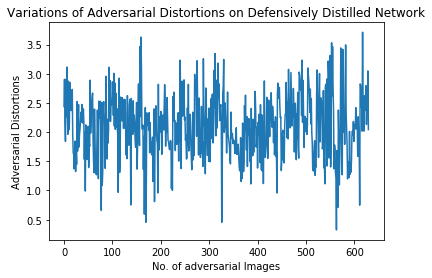


Evaluation Metrics:-
Minimum Distortion to break an Defensively distilled Network: 0.32466657572963026
Average Distortion to break an Defensively distilled Network: 2.095786354192293
Maximum Distortion to break an Defensively distilled Network: 3.7105121569560913


In [17]:
# plotting the metrics
plt.plot(iterations, distortions)
plt.title('Variations of Adversarial Distortions on Defensively Distilled Network')
plt.ylabel('Adversarial Distortions')
plt.xlabel('No. of adversarial Images')
plt.show()
print('\nEvaluation Metrics:-')
print('Minimum Distortion to break an Defensively distilled Network: {}'.format(min(distortions)))
print('Average Distortion to break an Defensively distilled Network: {}'.format(sum(distortions)/len(distortions)))
print('Maximum Distortion to break an Defensively distilled Network: {}'.format(max(distortions)))

####**Classify and Store Adversarial Images for Undistilled Network**

In [16]:
#reference: https://github.com/sabSAThai/EE769-project/blob/master/scripts/evaluate.py

adv = np.load('adv.npy')
ip = np.load('ip_img.npy')
labels = np.load('labels.npy')
digits = np.arange(0,10)
flags = np.zeros(10)

if not os.path.exists("results"):
    os.mkdir("results")

with tf.Session() as sess:
    model =  MNISTModel("models/mnist", sess)
    for i in range(0, 69):
        c = 9 * i
        l = model.model.predict(ip[c: c+1])
        index = np.argmax(l)
        print(i)
        print(l)
        print(index)
        print("next")

        if flags[index] == 0:
            if not os.path.exists("results/"+ str(index)):
                os.mkdir("results/" + str(index))

            for j in range(10):
                I = adv[c+j][:,:,0]
                I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save("results/" + str(index) + "/" + str(j) + ".png")
                #plt.imsave("results/" + str(index) + "/" + str(j), adv[c+j][:,:,0])
        
        flags[index] = 1
        if np.sum(flags) == 10:
            break

0
[[ -6.3573284   4.6431723   1.5238429  -2.670997    1.965811   -3.452602
  -18.069532   27.560114  -10.968164   -2.4666653]]
7
next
1
[[ -1.5086432    0.9948515   39.63966     -7.810951    -4.2050242
  -19.426731    -0.45531768  -2.8779242   -1.6545254  -20.069136  ]]
2
next
2
[[ -6.490437   22.912136   -1.644029  -10.382511    1.8822789  -2.4356742
   -2.4537416   2.3716457  -3.7982354  -5.575609 ]]
1
next
3
[[ 29.671698  -12.04435    -1.8313273  -8.397709  -10.12747    -6.0170593
    5.7433386  -7.0726523  -1.2135887  -2.2089558]]
0
next
4
[[-10.673836     0.27504706  -7.567711   -14.987957    37.135662
   -4.317975    -1.5332204    2.0252736   -7.299264     8.4852705 ]]
4
next
5
[[ -7.0165896  27.737421   -2.115164  -13.075096    2.5506918  -3.9259002
   -2.8734808   1.9603406  -3.4924328  -6.6361628]]
1
next
6
[[-15.008426    10.076768   -12.548914   -15.2153      31.307138
   -4.263047    -4.682423     0.45244953   5.7687316    5.9960456 ]]
4
next
7
[[ -4.8291817  -9.496646   -4

###**Execute L2 Adversarial Attacks on the Defensively Distilled Neural Network**

In [18]:
#Reference : https://github.com/carlini/nn_robust_attacks/blob/master/test_attack.py

distortions = []
iterations = []

with tf.Session() as sess:
    model = MNISTModel("models/mnist-distilled-100", sess)
    attack = l2_attack(sess, model, batch_size = 9, max_iterations = 1000, confidence = 0)
    inputs, targets = generate_data(X_test, Y_test, samples=70, targeted = True, start = 0, inception = False)
    start_time = time.time()
    adv = attack.attack(inputs, targets) #Get the set of 630 adversarial Images
    np.save("adv_distilled",adv)
    print(adv.shape)
    print("--- Adversarial Examples Generation Time: %s seconds ---" % (time.time() - start_time))
    for i in range(len(adv)):
        print("Classification:", model.model.predict(adv[i:i+1]))
        distortion = np.sum((adv[i]-inputs[i])**2)** 0.5
        print("Total distortion:", distortion)
        iterations.append(i)
        distortions.append(distortion)

go up to 630
tick 0
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (23.114733, 23.10603, 0.008703094)
Losses:   100 (22.40923, 21.563456, 0.84577405)
Losses:   200 (22.384735, 21.503183, 0.8815521)
Losses:   300 (20.355099, 17.37156, 2.9835393)
Losses:   400 (20.17568, 17.173622, 3.0020585)
Losses:   500 (20.140268, 17.126778, 3.0134914)
Losses:   600 (20.132725, 17.11922, 3.0135045)
Losses:   700 (20.12993, 17.113138, 3.016793)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (231.06897, 231.06026, 0.008705573)
Losses:   100 (158.45917, 126.28389, 32.17528)
Losses:   200 (118.21326, 51.92767, 66.28558)
Losses:   300 (76.60828, 17.467442, 59.140835)
Losses:   400 (61.882076, 9.3486595, 52.533417)
Losses:   500 (57.311523, 5.925089, 51.386436)
Losses:   600 (55.437366, 5.1

###**Variations of Distortions on Defensively Distilled Network**

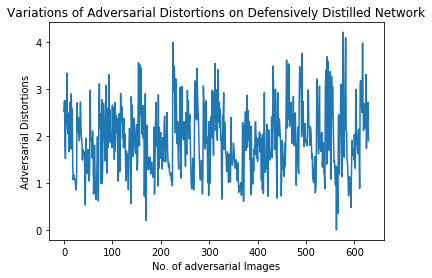


Evaluation Metrics:-
Minimum Distortion to break an Defensively distilled Network: 0.007123260771383253
Average Distortion to break an Defensively distilled Network: 1.9190399634901278
Maximum Distortion to break an Defensively distilled Network: 4.200071679366485


In [19]:
# plotting the metrics
plt.plot(iterations, distortions)
plt.title('Variations of Adversarial Distortions on Defensively Distilled Network')
plt.ylabel('Adversarial Distortions')
plt.xlabel('No. of adversarial Images')
plt.show()
print('\nEvaluation Metrics:-')
print('Minimum Distortion to break an Defensively distilled Network: {}'.format(min(distortions)))
print('Average Distortion to break an Defensively distilled Network: {}'.format(sum(distortions)/len(distortions)))
print('Maximum Distortion to break an Defensively distilled Network: {}'.format(max(distortions)))

####**Classify and Store Adversarial Images for Defensively distilled Network**

In [20]:
#reference: https://github.com/sabSAThai/EE769-project/blob/master/scripts/evaluate.py

adv = np.load('adv_distilled.npy')
ip = np.load('ip_img.npy')
labels = np.load('labels.npy')
digits = np.arange(0,10)
flags = np.zeros(10)

if not os.path.exists("distilled_results"):
    os.mkdir("distilled_results")

with tf.Session() as sess:
    model = MNISTModel("models/mnist-distilled-100", sess)
    for i in range(0, 69):
        c = 9 * i
        l = model.model.predict(ip[c: c+1])
        index = np.argmax(l)
        print(i)
        print(l)
        print(index)
        print("next")

        if flags[index] == 0:
            if not os.path.exists("distilled_results/"+ str(index)):
                os.mkdir("distilled_results/" + str(index))

            for j in range(10):
                I = adv[c+j][:,:,0]
                I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save("distilled_results/" + str(index) + "/" + str(j) + ".png")
        
        flags[index] = 1
        if np.sum(flags) == 10:
            break

0
[[ -316.76923   363.37177   189.34695   265.35928  -405.56638  -568.89233
  -1750.446    2355.414    -288.25156   496.2352 ]]
7
next
1
[[ 523.0837    306.75638  2309.606    -214.03304  -472.63104  -693.04047
   -34.381542 -354.98053   118.90634  -802.7381  ]]
2
next
2
[[-3.34080048e+02  1.66857678e+03 -1.11269295e+02 -8.27163818e+02
   2.10142944e+02 -2.64401062e+02 -5.99432945e+01 -1.60048556e+00
  -9.07833672e+00 -3.79620178e+02]]
1
next
3
[[2221.1755  -808.4418    95.71852 -853.5749  -300.43738   52.32295
   750.2126  -126.85175 -205.32988  398.75146]]
0
next
4
[[-366.89838  -120.234886 -152.45297  -628.95764  2070.7578   -340.03317
  -328.5365   -397.18665  -237.37805  1004.0203  ]]
4
next
5
[[ -331.7289    1965.7845    -169.111    -1003.75977    336.30997
   -529.50104   -243.03186    130.35231    -35.204193  -234.45428 ]]
1
next
6
[[-1317.0739      74.065056  -601.7522   -1180.8646    2038.5662
   -140.874     -819.0524     -41.9371    1091.681     1073.7953  ]]
4
next
7
[[ -44

###**Referred Sources**

1. Towards Evaluating the Robustness of Neural Networks authored by Nicholas Carlini & David Wagner, University of California, Berkeley.
2. https://openai.com/blog/adversarial-example-research/
3. https://github.com/carlini/nn_robust_attacks
4. https://github.com/sabSAThai/EE769-project